# Introduction to Deep Learning Lab - Part II

In the lab exercises today, you will:

1.   Interpret learning curves and apply two key strategies (capacity and callbacks) to correct for **underfitting and overfitting**
2.   Experiment with two kinds of special layers, not containing any neurons themselves, but instead adding functionality that can assist with model training: **dropout and batch normalization** 
3.   Apply a special loss function (cross-entropy), evaluation metric (accuracy) and activation function (sigmoid) for **binary classification**.

When you are ready, run the code cells below to set everything up!


## Setting Up the Workspace

In [18]:
#!pip install sklearn
import sklearn
sklearn.__version__

'1.2.2'

In [19]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn import set_config
from IPython.display import display

from sklearn.linear_model import LinearRegression
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation



In [20]:
# Setup plotting
plt.style.use('seaborn-whitegrid')

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

<ipython-input-20-e8fedecc2a49>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Loading the Data

We will use the *BigMart* data again with the sales per SKU and per store. In the next few cells we will load the data and use the pipeline to preprocess the data. Just like we did in class before.

In [21]:
#import pandas as pd
#import numpy as np

df_sales = pd.read_csv('https://www.dropbox.com/s/yqaymhdf7bvvair/bigmart_sales_predictions.csv?dl=1')
df_sales.head(5)

#Remove columns we will not use today
df_sales = df_sales.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'])

#Normalize ItemFatContent
df_sales['Item_Fat_Content'] = df_sales['Item_Fat_Content'].replace(
    {'Low Fat': 0,
     'LF': 0,
     'low fat': 0,
     'Regular': 1,
     'reg': 1})
df_sales['Item_Fat_Content'].value_counts()

0    5517
1    3006
Name: Item_Fat_Content, dtype: int64

## Pre-processing Pipeline

In [22]:
#from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
#from sklearn.compose import make_column_transformer, make_column_selector
#from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import train_test_split
#from sklearn.impute import SimpleImputer
#from sklearn import set_config
#from sklearn.pipeline import Pipeline

#Establish each pipeline for differente feature types
categorical_features = ['Item_Type','Outlet_Location_Type','Outlet_Type']
cat_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

categorical_ordinal_features = ['Outlet_Size']
cat_ord_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehotencoder', OrdinalEncoder(handle_unknown='error',
                                     categories=[['Missing','Small','Medium','High']]))])

num_features = ['Item_Weight','Item_Fat_Content','Item_MRP']
num_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer()),
    ('standardscaler', MinMaxScaler())])

#Create rail switch to correctly route each column to the correct pipel
preprocessor = make_column_transformer(
    (cat_pipe, categorical_features),
    (cat_ord_pipe, categorical_ordinal_features),
    (num_pipe, num_features), verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Type', 'Outlet_Location_Type',
                                  'Outlet_Type']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OrdinalEncoder(categories=[['Missing',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High']]))]),
                                 ['Outlet_Size']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  MinMaxScaler())]),
                                 ['Item_Weight', 'Item_Fat_Content',
                                  'Item_MRP'])],
                  verbose_feature_names_out=False)

## Define Target, Features and Train-test Split

In [23]:
target = "Item_Outlet_Sales"
y = df_sales[target].copy()
X = df_sales.drop(columns=[target]).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) #default is 80/20
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
7477,8.365,0,0.120256,Hard Drinks,39.2506,NaN,Tier 3,Grocery Store
5089,13.650,0,0.015944,Breads,231.9668,NaN,Tier 2,Supermarket Type1
6992,14.300,1,0.000000,Fruits and Vegetables,89.8856,Medium,Tier 3,Supermarket Type2


In [24]:
#We first need to fit each step in our pipeline to the training data.
preprocessor.fit(X_train)

#Now we can transform our data, with the steps specified in the pipeline
Xprocessed_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
Xprocessed_test_df = pd.DataFrame(preprocessor.transform(X_test),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_test.index)
display(Xprocessed_train_df)

,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,...,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Item_Weight,Item_Fat_Content,Item_MRP
7477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.226853,0.0,0.033789
5089,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.541530,0.0,0.851775
6992,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.580232,1.0,0.248710
6264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.464126,0.0,0.014990
4374,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.108663,0.0,0.622858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.836261,0.0,0.548958
7763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.494984,0.0,0.020072
5218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.081274,1.0,0.080982
1346,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.657636,0.0,0.341956


In [25]:
# make back-up copy of original train target and validation
y_train_orig = y_train 
y_test_orig = y_test 

#Log transform target instead of standardizing
y_train = np.log(y_train) 
y_test = np.log(y_test) 

input_shape = [Xprocessed_train_df.shape[1]] # number of columns
print("Input shape: {}".format(input_shape))

Input shape: [27]


---
# Lab Exercise 1. *Underfitting and Overfitting*


Now, you’ll learn how to improve training outcomes: by adding capacity to prevent underfitting, and by including early stopping callbacks to prevent overfitting.


## 1) Evaluate Baseline

Let's get back to the simplest network, the linear model. This model has low capacity. 

Run the following cell without any changes to train a linear model on the *Big Mart* dataset.

Minimum Validation Loss: 0.4131


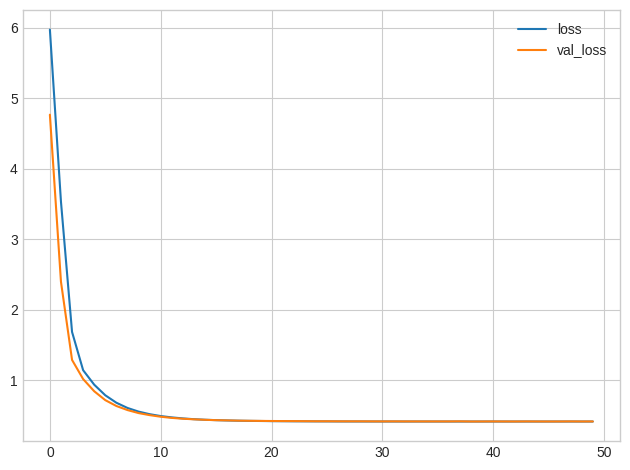

In [26]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)


history = model.fit(
    Xprocessed_train_df, y_train,
    validation_data=(Xprocessed_test_df, y_test), #Validation_data adds valdiation to each of the epoch
    batch_size=16,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of the training hard to see, so let's start at epoch 10 instead. 

Minimum Validation Loss: 0.4131


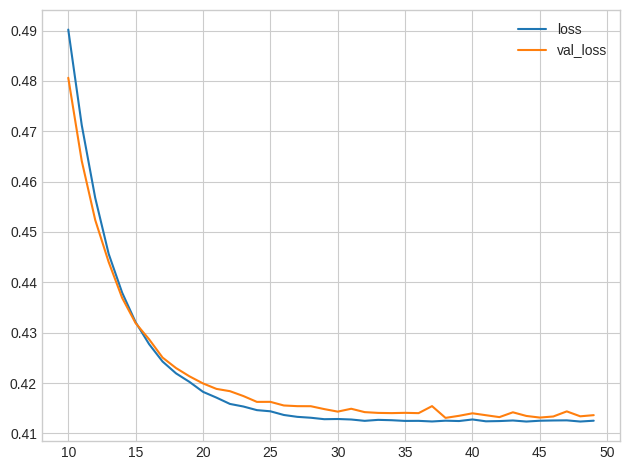

In [27]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### Q: *Would you say this model is underfitting, overfitting, or just right?*

Please explain your answer in the empty cell below.

Answer:  The blue line of training loss seems like the error rate is lowering and also the validation loss is reducing. however usually after some more epochs we should be able to see taht the validaiton score should go up as the training error keeps dropping. So as per the data shown it is still not underfitting. we need to see the orange line how it goes ahead.


## 2) Add Capacity

Now let's add some capacity to our network. We'll add two hidden layers, one with 128 units and one 64 units.
Run the next cell to train the network and see the learning curves.

Epoch 1/50
400/400 [==============================] - 1s 2ms/step - loss: 0.9004 - val_loss: 0.4410
Epoch 2/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4463 - val_loss: 0.4463
Epoch 3/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4377 - val_loss: 0.4245
Epoch 4/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4336 - val_loss: 0.4219
Epoch 5/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4279 - val_loss: 0.4172
Epoch 6/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4304 - val_loss: 0.4224
Epoch 7/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4203 - val_loss: 0.4254
Epoch 8/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4188 - val_loss: 0.4274
Epoch 9/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4155 - val_loss: 0.4984
Epoch 10/50
400/400 [==============================] - 1s 2ms/step - loss: 0.4118 - val_loss: 0.4167

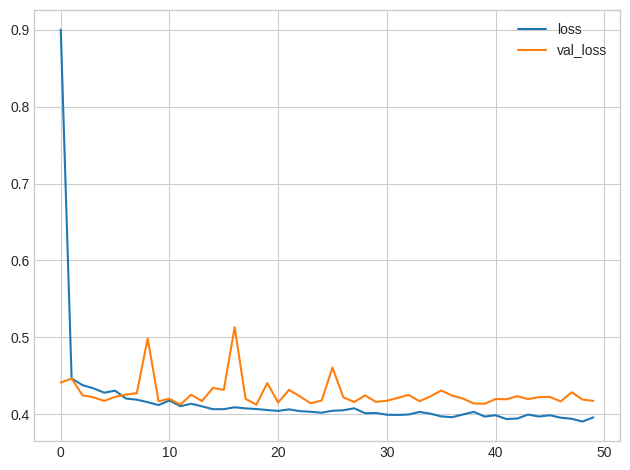

In [28]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train,
    validation_data=(Xprocessed_test_df, y_test),
    batch_size=16,
    epochs=50,
    verbose=1, # suppress output since we'll plot the curves
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### Q: *What is your evaluation of these curves: underfitting, overfitting, or just right?*

Please explain your answer in the empty cell below.

Answer: Its overfitting as the the orange line is going up so there is some level of overfitting happening. 

## 3) Define Early Stopping Callback

Now define early stopping callbacks that wait 5 epochs (`patience`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [31]:
# YOUR CODE HERE: Define early stopping callbacks
#from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # number of epochs to wain
    patience=5, # minimun change in loss function
    restore_best_weights=True, # restore the weights with the best loss
)

## 4) Train and Interpret

Now run the following cell to train the model and get the learning curves. Notice the `callbacks` argument in `model.fit`.

Minimum Validation Loss: 0.4090


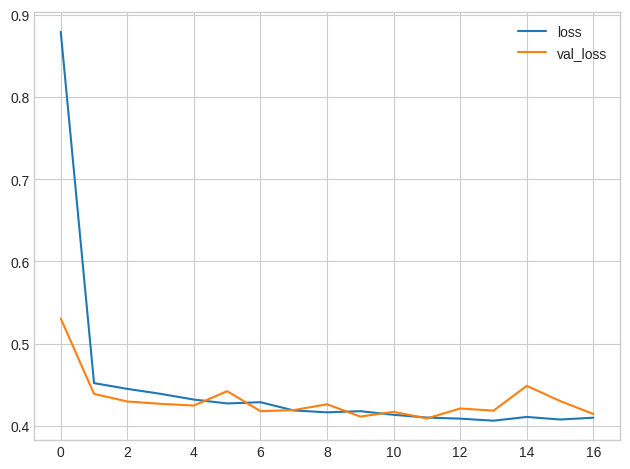

In [32]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train,
    validation_data=(Xprocessed_test_df, y_test),
    batch_size=16,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0, # suppress output since we'll plot the curves
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### Q: *Was adding early stopping* `callbacks` *an improvement compared to training without early stopping?*

Please explain your answer in the empty cell below.


Answer: It stops early and we can see that the validation losses are not increasing and stops where it sees validation losses increasing as training losses increases. 

### BONUS: *Try experimenting with* `patience` *and* `min_delta`. *What effect do these parameters have?*

Please explain your answer in the empty cell below.

In [33]:
# YOUR CODE HERE: Define early stopping callbacks
#from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # number of epochs to wain
    patience=35, # minimun change in loss function
    restore_best_weights=True, # restore the weights with the best loss
)

Minimum Validation Loss: 0.4068


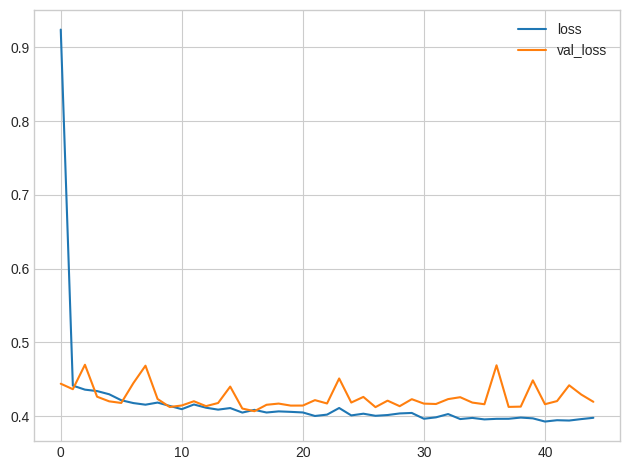

In [34]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train,
    validation_data=(Xprocessed_test_df, y_test),
    batch_size=16,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0, # suppress output since we'll plot the curves
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Answer:: With min stop to be higher, the epochs will be more as there can be situations where the error rates can be different across those min epochs. The graph also shows taht. Changing the min drop affects. Increase that allows the early stoppage much earlier. 

---
# Lab Execise 2. *Dropout and Batch Normalization*

## 1) Add Dropout to our last Model

**Add two dropout layers** to the last model (copied below for convenience), inserting one dropout layer after the `Dense` layer with 128 units, and one dropout layer after the `Dense` layer with 64 units. 

```
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
```

Set the dropout rate on both dropout layers to `0.3`.

In [36]:
# YOUR CODE HERE: Add two 30% dropout layers, one after the Dense layer with 128 units, and one after the Dense layer iwth 64 units 
#model = keras.Sequential([
#    layers.Dense(128, activation='relu', input_shape=input_shape),
#    layers.Dense(64, activation='relu'),
#    layers.Dense(1)
#])

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape), # Dense layer with ReLU and input shape
    layers.Dropout(rate=0.3), # Dropout layer 0.3
    layers.Dense(64, activation='relu'), # Dense layer with ReLU
    layers.Dropout(rate=0.3), # Dropout layer 0.3
    layers.Dense(1), # Dense output layer 
])

## 2) Evaluate Dropout

Now run this next cell to train the model see the effect of adding dropout.

Minimum Validation Loss: 0.4059


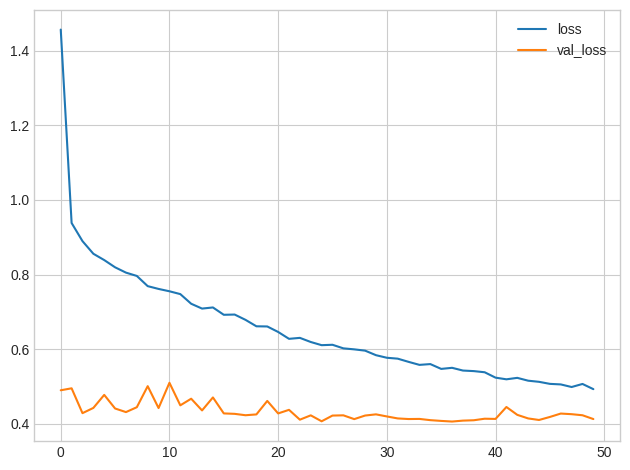

In [37]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    Xprocessed_train_df, y_train,
    validation_data=(Xprocessed_test_df, y_test),
    batch_size=16,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

### Q: *Recall that this model tended to overfit the data early in the training. Did adding dropout seem to help prevent overfitting this time?*

Please explain your answer in the empty cell below.



Answer: I think it did. we can see that there is a drop in the training loss and the validation data is almost constant. The dropout helps in reducing the increase in validation losses, and thus avoid overfitting

## 3) Explore Effect of Normalization 

Now, we'll switch topics to explore how batch normalization can fix problems in training neural networks. Initially we won't do any standardization of input data. This will make the effect of batch normalization much more apparent.

In [38]:
#Establish each pipeline for different feature types
categorical_features = ['Item_Type','Outlet_Location_Type','Outlet_Type']
cat_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

categorical_ordinal_features = ['Outlet_Size']
cat_ord_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehotencoder', OrdinalEncoder(handle_unknown='error',
                                     categories=[['Missing','Small','Medium','High']]))])

#REMOVED SCALER BELOW!
num_features = ['Item_Weight','Item_Fat_Content','Item_MRP']
num_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer())])

#Create rail switch to correctly route each column to the correct pipel
preprocessor = make_column_transformer(
    (cat_pipe, categorical_features),
    (cat_ord_pipe, categorical_ordinal_features),
    (num_pipe, num_features), verbose_feature_names_out=False)
preprocessor

#We first need to fit each step in our pipeline to the training data.
preprocessor.fit(X_train)
#Now we can transform our data, with the steps specified in the pipeline
Xprocessed_train_unscaled_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
Xprocessed_test_unscaled_df = pd.DataFrame(preprocessor.transform(X_test),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_test.index)
display(Xprocessed_train_unscaled_df)

,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,...,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Item_Weight,Item_Fat_Content,Item_MRP
7477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,8.36500,0.0,39.2506
5089,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,13.65000,0.0,231.9668
6992,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,14.30000,1.0,89.8856
6264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,12.35000,0.0,34.8216
4374,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6.38000,0.0,178.0344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,18.60000,0.0,160.6236
7763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,12.86826,0.0,36.0190
5218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,3.0,5.92000,1.0,50.3692
1346,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,15.60000,0.0,111.8544


Run the following cell to train the network on **unstandardized** *Big Mart* data.

Minimum Validation Loss: 2122.3262


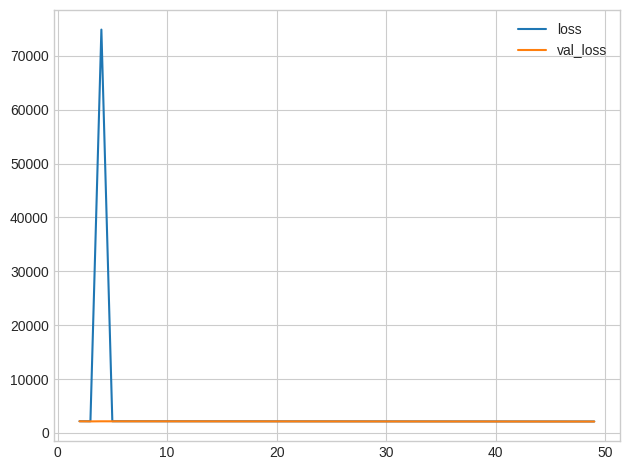

In [39]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)

history = model.fit(
    Xprocessed_train_unscaled_df, y_train_orig,
    validation_data=(Xprocessed_test_unscaled_df, y_test_orig),
    batch_size=64,
    epochs=50,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[2:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

### Q: *Trying to train this network on the dataset without scaling of input features may fail. Did you end up with a blank graph? If you did indeed get a graph of the training and validation loss curves, what do you notice about the value of loss at convergence?*

Please explain your answer in the empty cell below.

Answer:  The graph is very weird as the error is flat for validation and the training loss has a spike but then goes flat. The error is constant which means there is some limiting factor that causes it to max out or peak out. 

Batch normalization can help correct problems like this!

## 4) Add Batch Normalization Layers

Add four `BatchNormalization` layers, one before each of the dense layers. (Remember to move the `input_shape` argument to the new first layer.)

In [40]:
# YOUR CODE HERE: Add a BatchNormalization layer before each Dense layer

model = keras.Sequential([
    layers.BatchNormalization(input_shape=[Xprocessed_train_unscaled_df.shape[1]]), # Batch Normalization including input shape
    layers.Dense(512, activation='relu'), # Dense layer with ReLU
    layers.BatchNormalization(), # Batch Normalization
    layers.Dense(512, activation='relu'), # Dense layer with ReLU
    layers.BatchNormalization(), # Batch Normalization
    layers.Dense(512, activation='relu'), # Dense layer with ReLU
    layers.BatchNormalization(), # Batch Normalization
    layers.Dense(1), # Dense output layer 
])

## 5) Evaluate Batch Normalization

Run the next cell to see if batch normalization will improve training of the model.

Minimum Validation Loss: 749.0551


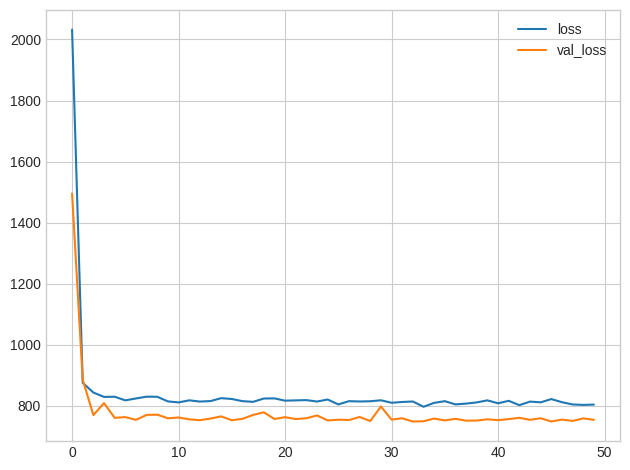

In [41]:
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)

history = model.fit(
    Xprocessed_train_df, y_train_orig,
    validation_data=(Xprocessed_test_df, y_test_orig),
    batch_size=16,
    epochs=50,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

### Q: *Did adding bach normalization help?*

Please explain your answer in the empty cell below.

Answer:  Seems like it. it stopped at orange layer became flat and not going up. Thus it helps to some extend.

By adaptively scaling the data as it passes through the network, batch normalization can let you train models on difficult datasets.

---
# Lab Exercise 3. *Binary classification*



## Loading the Data

In [47]:
target = "Item_Outlet_Sales"
y = df_sales[target].copy()
y_median = y.median()
X = df_sales.drop(columns=[target]).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) #default is 80/20
X_train.head(3)

Xprocessed_train_unscaled_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
Xprocessed_test_unscaled_df = pd.DataFrame(preprocessor.transform(X_test),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_test.index)

y_train_class = (y_train > y_median).astype('int')
y_test_class = (y_test > y_median).astype('int')

In [48]:
y_test_class.value_counts()

0    1090
1    1041
Name: Item_Outlet_Sales, dtype: int64


## 1) Define Model 

The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:

<figure style="padding: 1em;">
<img src="https://i.ibb.co/1nhLzZ9/data-schema.png" width="400" alt="Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.">
<figcaption style="textalign: center; font-style: italic"><center>Diagram of a binary classifier.</center></figcaption>
</figure>


In [49]:
# YOUR CODE HERE: Define the model given in the diagram

model = keras.Sequential([
    layers.BatchNormalization(input_shape=[Xprocessed_train_unscaled_df.shape[1]]), # Batch Normalization with input shape
    layers.Dense(64, activation='relu'), # Dense layer with ReLU
    layers.BatchNormalization(), # Batch Normalization
    layers.Dropout(rate=0.1), # Dropout layer 0.1
    layers.Dense(64, activation='relu'), # Dense layer with ReLU
    layers.BatchNormalization(), # Batch Normalization
    layers.Dropout(rate=0.1), # Dropout layer 0.1
    layers.Dense(1, activation='sigmoid'), # Dense output layer with sigmoid
])


## 2) Add Optimizer, Loss Function and Evaluation Metric

Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [50]:
# YOUR CODE HERE: Compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric

model.compile(
    optimizer = 'adam', # optimizer
    loss = 'binary_crossentropy' , # loss function for binary classification
    metrics = ['binary_accuracy'] # metric for binary classification
)

## 3) Train and Evaluate

Run the cell below to train the model and view the learning curves. It could take a minute or two. 

<Axes: title={'center': 'Accuracy'}>

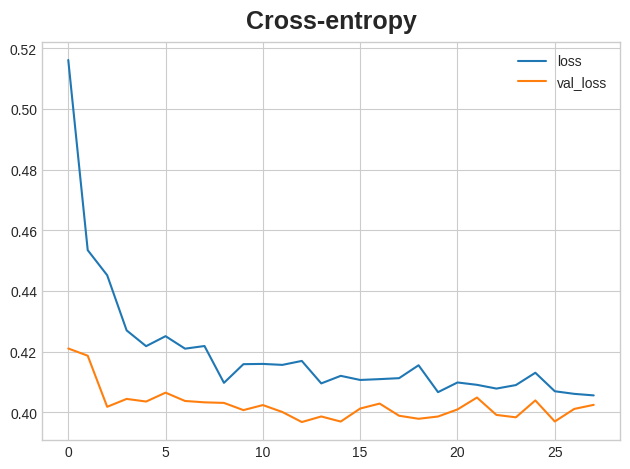

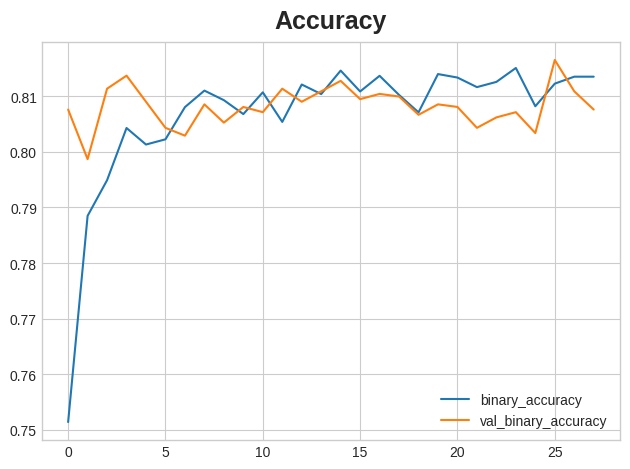

In [51]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.0001,
    restore_best_weights=True,
)
history = model.fit(
    Xprocessed_train_unscaled_df, y_train_class,
    validation_data=(Xprocessed_test_unscaled_df, y_test_class),
    batch_size=16,
    verbose=0,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

### Q: *What do you think about the learning curves? Does it look like the model underfit or overfit? Was the cross-entropy loss a good stand-in for accuracy?*

Please explain your answer in the empty cell below.



Answer: In both we can see that the training loss keeps improving over time or eopchs. the validation loss improves then starts decreasing suggesting that the model is trying to overfit the data . Even with the early stop and drop out and batch normalization we can see that the its not helping as the validation loss starts to go up. 
Cross entropy seems like a good measure and cn be used for accuracy. The accuracy seems to be have some more variations as compared to the the cross entropy. I think it might be due to the converting the predictions into labels and then calculating errors while the cross entropy takes the value directly.